#### Farutin Vadim

#### Homework04

In [2]:
import numpy as np
import operator
import csv
import matplotlib.pyplot as plt

Reading datasets.

In [22]:
def read_noisysine():
    D = []
    
    with open('./Datasets/noisysine.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            row = list(map(float, row))
            D.append(np.array([np.array([row[0]]), row[1]]))

    return np.array(D)

In [6]:
def read_hydrodynamics():
    D = []
    
    with open('./Datasets/hydrodynamics.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        next(dataset_reader)
        for row in dataset_reader:
            row = list(map(float, row))
            D.append(np.array([np.array(row[:-1]), row[-1]]))

    return np.array(D)

In [3]:
def read_tsp():
    D = []
    
    with open('./Datasets/tsp.csv', newline='') as csv_file:
        dataset_reader = csv.reader(csv_file, delimiter=',')
        for row in dataset_reader:
            row = list(map(float, row))
            D.append(np.array(row[1:]))

    return np.array(D)

In [4]:
def extract_labels(D):
    X = np.array([row[0] for row in D])
    Y = np.array([row[1] for row in D])
    
    return X, Y

In [5]:
from sklearn.model_selection import train_test_split

def split_dataset(D, train_size):
    X, Y = extract_labels(D)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, test_size=1 - train_size)
    D_train = np.array([[x_row, y_row] for x_row, y_row in zip(X_train, Y_train)])
    D_test = np.array([[x_row, y_row] for x_row, y_row in zip(X_test, Y_test)])
    
    return D_train, D_test

#### Regression

Datasets: noisysine.csv, hydrodynamics.csv. Both should be split into train and validate datasets (80% / 20%).

In every task, you need to calculate the R2 score (for both datasets) and draw the resulting function on the noisysine dataset.

In [49]:
def r2(X, Y, h):
    Y_h = h(X)
    u = np.sum((Y_h - Y) ** 2)
    v = np.sum((Y - np.mean(Y)) ** 2)
    r = 1 - u / v
    
    return r

In [50]:
def plot_regression(D, h, title):
    X, Y = extract_labels(D)
    x_min, x_max = X.min() - 1, X.max() + 1
    X_h = np.arange(x_min, x_max, 0.02).reshape(-1, 1)
    Y_h = h(X_h)
    
    plt.scatter(X, Y, color='blue')
    plt.plot(X_h, Y_h, color='red')

    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()

1. (3) Implement linear and polynomial regression algorithms (for noisysine use the powers from 2 to 5, for hydrodynamics use the power of 2). No regularization.

In [56]:
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(D, degree):
    D_train, D_val = split_dataset(D, 0.8)
    X_train, Y_train = extract_labels(D_train)
    X_train_extended = PolynomialFeatures(degree=degree).fit_transform(X_train)
    X_val, Y_val = extract_labels(D_val)
    
    w = np.linalg.inv(np.transpose(X_train_extended) @ X_train_extended) @ np.transpose(X_train_extended) @ Y_train
    h = lambda x: PolynomialFeatures(degree=degree).fit_transform(x) @ w
    score = r2(X_val, Y_val, h)
    
    return h, score

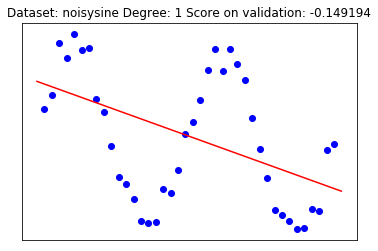

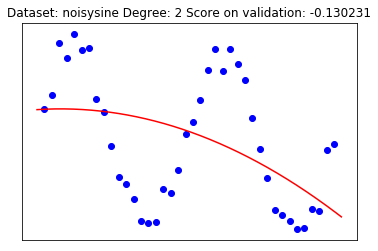

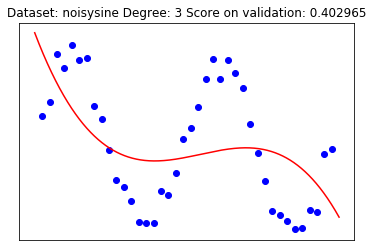

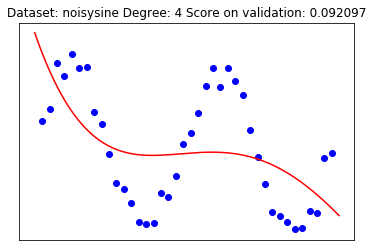

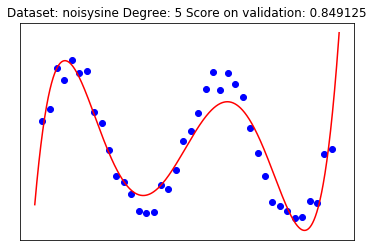

In [57]:
D = read_noisysine()
degrees = range(1, 6)

for degree in degrees:
    h, score = polynomial_regression(D, degree)
    plot_regression(D, h, 'Dataset: noisysine Degree: %d Score on validation: %f' % (degree, score))

In [183]:
D = read_hydrodynamics()
degrees = np.array([1, 2, 4])

for degree in degrees:
    h, score = polynomial_regression(D, degree)
    print('Dataset: hydrodynamics Degree: %d Score on validation: %f' % (degree, score))

Dataset: hydrodynamics Degree: 1 Score on validation: 0.660054
Dataset: hydrodynamics Degree: 2 Score on validation: 0.932808
Dataset: hydrodynamics Degree: 4 Score on validation: -19.211490


2. (2) Implement a ridge regression algorithm and optimize the regularization parameter for every case from task #1.

In [59]:
from sklearn.preprocessing import PolynomialFeatures

def polynomial_ridge_regression(D, degree, alpha):
    D_train, D_val = split_dataset(D, 0.8)
    X_train, Y_train = extract_labels(D_train)
    X_train_extended = PolynomialFeatures(degree=degree).fit_transform(X_train)
    X_val, Y_val = extract_labels(D_val)
    
    w = np.linalg.inv(np.transpose(X_train_extended) @ X_train_extended \
                      + alpha * np.identity(X_train_extended.shape[1])) \
        @ np.transpose(X_train_extended) @ Y_train
    h = lambda x: PolynomialFeatures(degree=degree).fit_transform(x) @ w
    score = r2(X_val, Y_val, h)
    
    return h, score

In [75]:
def optimize_ridge_regression(D, degree):
    alphas = [10 ** (-i) for i in range(16)]
    best_h = None
    best_score = None
    
    for alpha in alphas:
        h, score = polynomial_ridge_regression(D, degree, alpha)

        if best_score is None or score > best_score:
            best_h = h
            best_score = score
            best_alpha = alpha

    return best_h, best_score, best_alpha

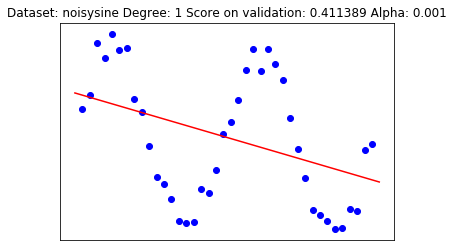

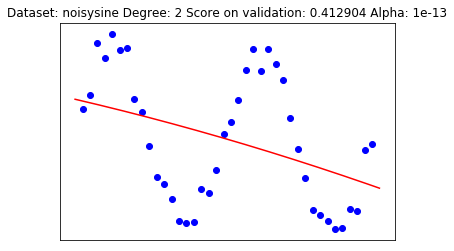

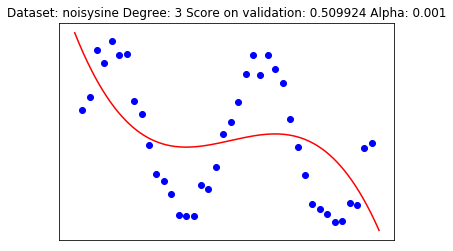

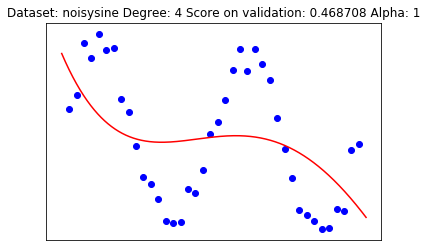

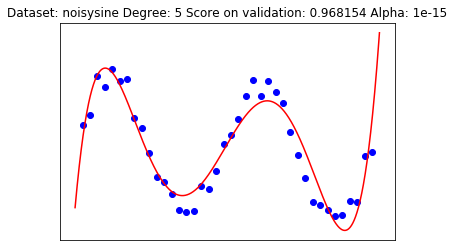

In [77]:
D = read_noisysine()
degrees = range(1, 6)

for degree in degrees:
    h, score, alpha = optimize_ridge_regression(D, degree)
    plot_regression(D, h, 'Dataset: noisysine Degree: %d Score on validation: %f Alpha: ' % (degree, score) + str(alpha))

In [184]:
D = read_hydrodynamics()
degrees = np.array([1, 2, 4])

for degree in degrees:
    h, score, alpha = optimize_ridge_regression(D, degree)
    print('Dataset: hydrodynamics Degree: %d Score on validation: %f Alpha: ' % (degree, score) + str(alpha))

Dataset: hydrodynamics Degree: 1 Score on validation: 0.688467 Alpha: 0.001
Dataset: hydrodynamics Degree: 2 Score on validation: 0.934837 Alpha: 1e-13
Dataset: hydrodynamics Degree: 4 Score on validation: 0.996529 Alpha: 1e-06


3. (3) Use the LASSO regression algorithm (i.e., from the sklearn2umber of used features.

In [100]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

def polynomial_LASSO_regression(D, degree, alpha):
    D_train, D_val = split_dataset(D, 0.8)
    X_train, Y_train = extract_labels(D_train)
    X_train_extended = PolynomialFeatures(degree=degree).fit_transform(X_train)
    X_val, Y_val = extract_labels(D_val)
    
    model = Lasso(alpha=alpha, max_iter=100000, tol=0.0001)
    model.fit(X_train_extended, Y_train)
    h = lambda x: model.predict(PolynomialFeatures(degree=degree).fit_transform(x))
    score = r2(X_val, Y_val, h)
    used_features = np.sum(model.coef_ != 0)
    
    return h, score, used_features

In [101]:
def optimize_LASSO_regression(D, degree):
    alphas = [10 ** (-i) for i in range(11)]
    best_h = None
    best_score = None
    best_used_features = None
    
    for alpha in alphas:
        h, score, used_features = polynomial_LASSO_regression(D, degree, alpha)

        if best_score is None or score > best_score:
            best_h = h
            best_score = score
            best_alpha = alpha
            best_used_features = used_features

    return best_h, best_score, best_alpha, best_used_features

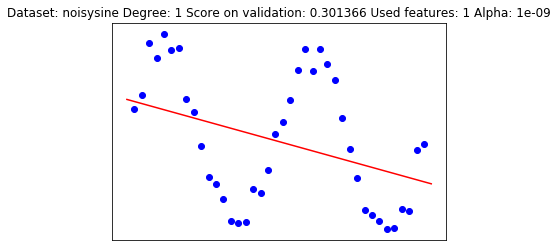

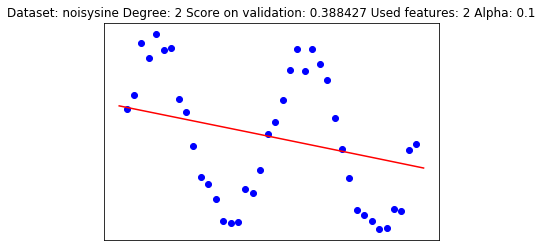

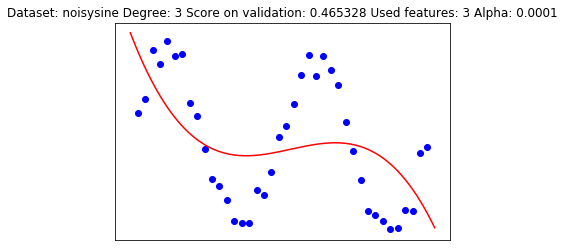

C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not co

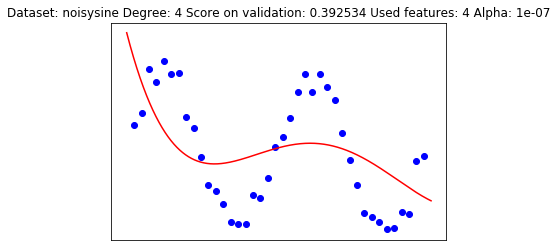

C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not co

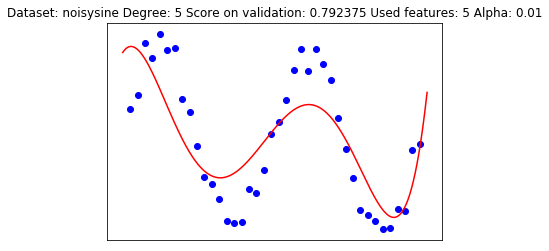

In [102]:
D = read_noisysine()
degrees = range(1, 6)

for degree in degrees:
    h, score, alpha, used_features = optimize_LASSO_regression(D, degree)
    plot_regression(D, h, 'Dataset: noisysine Degree: %d Score on validation: %f Used features: %d Alpha: ' % (degree, score, used_features) + str(alpha))

In [105]:
D = read_hydrodynamics()
degrees = np.array([1, 2, 4])

for degree in degrees:
    h, score, alpha, used_features = optimize_LASSO_regression(D, degree)
    print('Dataset: hydrodynamics Degree: %d Score on validation: %f Used features: %d Alpha: ' % (degree, score, used_features) + str(alpha))

Dataset: hydrodynamics Degree: 1 Score on validation: 0.688599 Used features: 5 Alpha: 0.001


C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not co

Dataset: hydrodynamics Degree: 2 Score on validation: 0.930728 Used features: 27 Alpha: 1e-09


C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not co

Dataset: hydrodynamics Degree: 4 Score on validation: 0.997907 Used features: 209 Alpha: 1e-10


C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


#### Global and Local Search

Dataset: tsp.csv - coordinates of points to visit.

In every task, you need to visualize the best-found path and output its length. The path is not cyclical, i.e., the starting and finishing points are not the same.


NOTICE - the distance should be in L1 (avenues and streets). The path should be drawn as L1 as well.

In [6]:
from scipy.spatial.distance import cityblock

def L1(X):
    return np.sum([cityblock(X[i], X[i + 1]) for i in range(len(X) - 1)])

In [7]:
def plot_path(X, title):
    path = np.array([[X[i // 2][0], X[i // 2 + i % 2][1]] for i in range(2 * len(X) - 1)])
    plt.plot(path[:, 0], path[:, 1])
    plt.scatter(X[:, 0], X[:, 1])
    plt.title(title)
    plt.show()

4. (2) Implement a Monte-Carlo search.

In [110]:
def monte_carlo(X):
    best_X = None
    best_len = None
    cur_X = X.copy()
    n = 1000
    
    for i in range(n):
        np.random.shuffle(cur_X)
        cur_len = L1(cur_X)
        
        if best_len is None or cur_len < best_len:
            best_X = cur_X.copy()
            best_len = cur_len
    
    return best_X, best_len

5. (2) Implement a random walk search.

In [135]:
def random_walk(X):
    cur_X = X.copy()
    np.random.shuffle(cur_X)
    len_X = len(X)
    n = 1000
    
    for i in range(n):
        a = np.random.randint(len_X)
        b = np.random.randint(len_X)
        cur_X[a], cur_X[b] = cur_X[b].copy(), cur_X[a].copy()
        
    return cur_X, L1(cur_X)

6. (4) Implement a hill climb algorithm.

In [8]:
def hill_climb(X):
    cur_X = X.copy()
    np.random.shuffle(cur_X)
    len_X = len(X)
    n = 1000
    
    for i in range(n):
        best_X = None
        best_len = None

        for j in range(len_X):
            for k in range(j + 1, len_X):
                cur_X[j], cur_X[k] = cur_X[k].copy(), cur_X[j].copy()
                cur_len = L1(cur_X)

                if best_len is None or cur_len < best_len:
                    best_X = cur_X.copy()
                    best_len = cur_len

                cur_X[j], cur_X[k] = cur_X[k].copy(), cur_X[j].copy()

        cur_X = best_X.copy()

    return cur_X, L1(cur_X)

7. (6) Implement a simulated annealing algorithm.

In [11]:
from scipy.special import softmax

def simulated_annealing(X):
    cur_X = X.copy()
    np.random.shuffle(cur_X)
    len_X = len(X)
    n = 1000
    min_T = 0.001
    max_T = 10000

    for i in range(n):
        cur_len = L1(cur_X)
        neighbours_len = []
        neighbours_idx = []        
        
        for j in range(len_X):
            for k in range(j + 1, len_X):
                cur_X[j], cur_X[k] = cur_X[k].copy(), cur_X[j].copy()
                neighbours_len.append(cur_len - L1(cur_X))
                neighbours_idx.append((j, k))
                cur_X[j], cur_X[k] = cur_X[k].copy(), cur_X[j].copy()
        
        cur_T = max_T - (max_T - min_T) * i / n
        P = softmax(np.array(neighbours_len) / cur_T)
        
        idx = np.random.choice(len(neighbours_idx), p=P)
        j, k = neighbours_idx[idx]
        cur_X[j], cur_X[k] = cur_X[k].copy(), cur_X[j].copy()
    
    return cur_X, L1(cur_X)

8. (8) Implement a genetic algorithm.

In [179]:
def crossover(a, b):
    m = len(a)
    prefix_len = np.random.randint(m)
    
    a_suffix = []
    for x in b:
        for y in a[prefix_len:]:
            if np.array_equal(x, y):
                a_suffix.append(x.copy())
    
    b_suffix = []
    for x in a:
        for y in b[prefix_len:]:
            if np.array_equal(x, y):
                b_suffix.append(x.copy())

    for i in range(m - prefix_len):
        a[prefix_len + i] = a_suffix[i].copy()
        b[prefix_len + i] = b_suffix[i].copy()
    
    return a, b

In [180]:
def mutate(X):
    len_X = len(X)
    a = np.random.randint(len_X)
    b = np.random.randint(len_X)
    X[a], X[b] = X[b].copy(), X[a].copy()

    return X

In [203]:
def genetic(X):
    n = 2000
    m = 30
    population = np.array([np.random.permutation(X) for i in range(m)])
    population_len = np.array([L1(member) for member in population])

    for i in range(n):
        indexes = np.argsort(population_len)
        a = population[indexes[0]].copy()
        b = population[indexes[1]].copy()
        a, b = crossover(a, b)
        a = mutate(a)
        b = mutate(b)
        population[indexes[-1]] = a.copy()
        population[indexes[-2]] = b.copy()
        population_len = np.array([L1(member) for member in population])
    
    indexes = np.argsort(population_len)
    return population[indexes[0]], population_len[indexes[0]]

#### Run all implemented algorithms.

In [9]:
D = read_tsp()

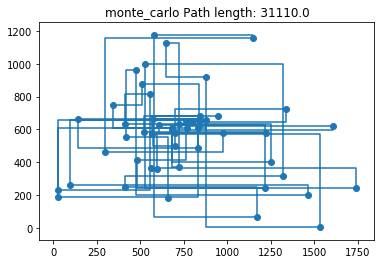

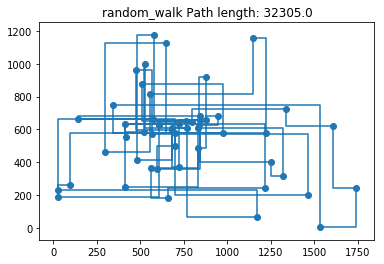

In [139]:
algorithms = [monte_carlo, random_walk]
titles = ['monte_carlo', 'random_walk']

for algorithm, title in zip(algorithms, titles):
    path, path_len = algorithm(D)
    plot_path(path, title + ' Path length: ' + str(path_len))

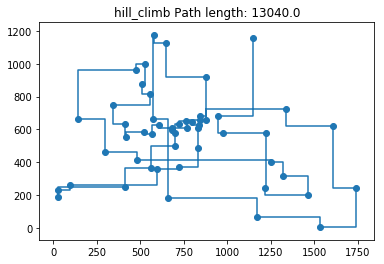

In [10]:
path, path_len = hill_climb(D)
plot_path(path, 'hill_climb' + ' Path length: ' + str(path_len))

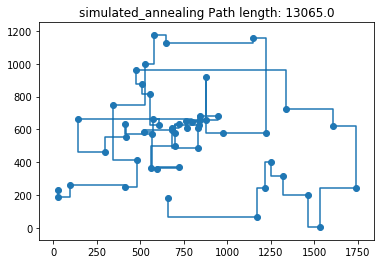

In [12]:
path, path_len = simulated_annealing(D)
plot_path(path, 'simulated_annealing' + ' Path length: ' + str(path_len))

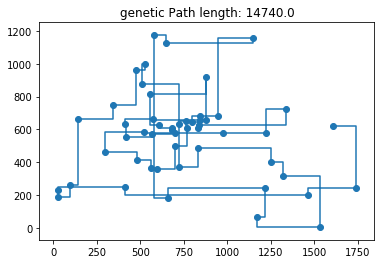

In [204]:
path, path_len = genetic(D)
plot_path(path, 'genetic' + ' Path length: ' + str(path_len))